## Import the required packages

In [79]:
!pip install -q tflite-model-maker
!sudo apt-get install libportaudio2
!pip install sounddevice

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libportaudio2 is already the newest version (19.6.0-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 42 not upgraded.


In [80]:
import numpy as np
import os

from tflite_model_maker.config import ExportFormat
from tflite_model_maker import model_spec
from tflite_model_maker import object_detector

import tensorflow as tf
assert tf.__version__.startswith('2')

tf.get_logger().setLevel('ERROR')
from absl import logging
logging.set_verbosity(logging.ERROR)

## Set dataset options

In [81]:
use_custom_dataset = True
dataset_is_split = False

## Split dataset function

In [82]:
import os
import random
import shutil

def split_dataset(images_path, annotations_path, val_split, test_split, out_path):
  """Splits a directory of sorted images/annotations into training, validation, and test sets.

  Args:
    images_path: Path to the directory with your images (JPGs).
    annotations_path: Path to a directory with your VOC XML annotation files,
      with filenames corresponding to image filenames. This may be the same path
      used for images_path.
    val_split: Fraction of data to reserve for validation (float between 0 and 1).
    test_split: Fraction of data to reserve for test (float between 0 and 1).
  Returns:
    The paths for the split images/annotations (train_dir, val_dir, test_dir)
  """
  _, dirs, _ = next(os.walk(images_path))

  train_dir = os.path.join(out_path, 'train')
  val_dir = os.path.join(out_path, 'validation')
  test_dir = os.path.join(out_path, 'test')

  IMAGES_TRAIN_DIR = os.path.join(train_dir, 'images')
  IMAGES_VAL_DIR = os.path.join(val_dir, 'images')
  IMAGES_TEST_DIR = os.path.join(test_dir, 'images')
  os.makedirs(IMAGES_TRAIN_DIR, exist_ok=True)
  os.makedirs(IMAGES_VAL_DIR, exist_ok=True)
  os.makedirs(IMAGES_TEST_DIR, exist_ok=True)

  ANNOT_TRAIN_DIR = os.path.join(train_dir, 'annotations')
  ANNOT_VAL_DIR = os.path.join(val_dir, 'annotations')
  ANNOT_TEST_DIR = os.path.join(test_dir, 'annotations')
  os.makedirs(ANNOT_TRAIN_DIR, exist_ok=True)
  os.makedirs(ANNOT_VAL_DIR, exist_ok=True)
  os.makedirs(ANNOT_TEST_DIR, exist_ok=True)

  # Get all filenames for this dir, filtered by filetype
  filenames = os.listdir(os.path.join(images_path))
  filenames = [os.path.join(images_path, f) for f in filenames if (f.endswith('.jpg'))]
  # Shuffle the files, deterministically
  filenames.sort()
  random.seed(42)
  random.shuffle(filenames)
  # Get exact number of images for validation and test; the rest is for training
  val_count = int(len(filenames) * val_split)
  test_count = int(len(filenames) * test_split)
  for i, file in enumerate(filenames):
    source_dir, filename = os.path.split(file)
    annot_file = os.path.join(annotations_path, filename.replace("jpg", "xml"))
    if i < val_count:
      shutil.copy(file, IMAGES_VAL_DIR)
      shutil.copy(annot_file, ANNOT_VAL_DIR)
    elif i < val_count + test_count:
      shutil.copy(file, IMAGES_TEST_DIR)
      shutil.copy(annot_file, ANNOT_TEST_DIR)
    else:
      shutil.copy(file, IMAGES_TRAIN_DIR)
      shutil.copy(annot_file, ANNOT_TRAIN_DIR)
  return (train_dir, val_dir, test_dir)

## Load your Pascal VOC dataset

In [83]:
if use_custom_dataset:

  # The ZIP file you uploaded:
  !unzip dataset.zip

  # Your labels map as a dictionary (zero is reserved):
  label_map = {1: 'lay'} 

  if dataset_is_split:
    # If your dataset is already split, specify each path:
    train_images_dir = 'dataset/train/imageaas'
    train_annotations_dir = 'dataset/train/annotations'
    val_images_dir = 'dataset/validation/images'
    val_annotations_dir = 'dataset/validation/annotations'
    test_images_dir = 'dataset/test/images'
    test_annotations_dir = 'dataset/test/annotations'
  else:
    # If it's NOT split yet, specify the path to all images and annotations
    images_in = 'dataset/images'
    annotations_in = 'dataset/annotations'

Archive:  dataset.zip
replace dataset/annotations/lay0.xml? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: dataset/annotations/lay0.xml  
  inflating: dataset/annotations/lay1.xml  
  inflating: dataset/annotations/lay10.xml  
  inflating: dataset/annotations/lay11.xml  
  inflating: dataset/annotations/lay12.xml  
  inflating: dataset/annotations/lay13.xml  
  inflating: dataset/annotations/lay14.xml  
  inflating: dataset/annotations/lay15.xml  
  inflating: dataset/annotations/lay16.xml  
  inflating: dataset/annotations/lay17.xml  
  inflating: dataset/annotations/lay18.xml  
  inflating: dataset/annotations/lay19.xml  
  inflating: dataset/annotations/lay2.xml  
  inflating: dataset/annotations/lay20.xml  
  inflating: dataset/annotations/lay21.xml  
  inflating: dataset/annotations/lay22.xml  
  inflating: dataset/annotations/lay23.xml  
  inflating: dataset/annotations/lay24.xml  
  inflating: dataset/annotations/lay25.xml  
  inflating: dataset/annotations/lay26.xml  
  i

## Split the dataset

In [84]:
# We need to instantiate a separate DataLoader for each split dataset
if use_custom_dataset:
  if dataset_is_split:
    train_data = object_detector.DataLoader.from_pascal_voc(
        train_images_dir, train_annotations_dir, label_map=label_map)
    validation_data = object_detector.DataLoader.from_pascal_voc(
        val_images_dir, val_annotations_dir, label_map=label_map)
    test_data = object_detector.DataLoader.from_pascal_voc(
        test_images_dir, test_annotations_dir, label_map=label_map)
  else:
    train_dir, val_dir, test_dir = split_dataset(images_in, annotations_in,
                                  val_split=0.2, test_split=0.2,
                                  out_path='split-dataset')
    train_data = object_detector.DataLoader.from_pascal_voc(
        os.path.join(train_dir, 'images'),
        os.path.join(train_dir, 'annotations'), label_map=label_map)
    validation_data = object_detector.DataLoader.from_pascal_voc(
        os.path.join(val_dir, 'images'),
        os.path.join(val_dir, 'annotations'), label_map=label_map)
    test_data = object_detector.DataLoader.from_pascal_voc(
        os.path.join(test_dir, 'images'),
        os.path.join(test_dir, 'annotations'), label_map=label_map)
    
  print(f'train count: {len(train_data)}')
  print(f'validation count: {len(validation_data)}')
  print(f'test count: {len(test_data)}')

train count: 31
validation count: 10
test count: 10


In [85]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Select model spec

Model Maker supports the EfficientDet-Lite family of object detection models that are compatible with the Edge TPU. (EfficientDet-Lite is derived from [EfficientDet](https://ai.googleblog.com/2020/04/efficientdet-towards-scalable-and.html), which offers state-of-the-art accuracy in a small model size). There are several model sizes you can choose from:

|| Model architecture | Size(MB)* | Latency(ms)** | Average Precision*** |
|-|--------------------|-----------|---------------|----------------------|
|| EfficientDet-Lite0 | 5.7       | 37.4            | 30.4%               |
|| EfficientDet-Lite1 | 7.6       | 56.3            | 34.3%               |
|| EfficientDet-Lite2 | 10.2      | 104.6           | 36.0%               |
|| EfficientDet-Lite3 | 14.4      | 107.6           | 39.4%               |
| <td colspan=4><br><i>* File size of the compiled Edge TPU models. <br/>** Latency measured on a desktop CPU with a Coral USB Accelerator. <br/>*** Average Precision is the mAP (mean Average Precision) on the COCO 2017 validation dataset.</i></td> |

Beware that the Lite2 and Lite3 models do not fit onto the Edge TPU's onboard memory, so you'll see even greater latency when using those, due to the cost of fetching data from the host system memory. Maybe this extra latency is okay for your application, but if it's not and you require the precision of the larger models, then you can [pipeline the model across multiple Edge TPUs](https://coral.ai/docs/edgetpu/pipeline/) (more about this when we compile the model below).

For this tutorial, we'll use Lite0:

In [86]:
spec = object_detector.EfficientDetLite0Spec()

## Create and train model

Now we need to create our model according to the model spec, load our dataset into the model, specify training parameters, and begin training. 

Using Model Maker, we accomplished all of that with [`create()`](https://www.tensorflow.org/lite/api_docs/python/tflite_model_maker/object_detector/create):

In [78]:
model = object_detector.create(train_data=train_data, 
                model_spec=spec, 
                validation_data=validation_data, 
                epochs=30, 
                batch_size=10, 
                train_whole_model=False)

Epoch 1/30
3/3 [==============================] - 21s 2s/step - det_loss: 1.7843 - cls_loss: 1.1704 - box_loss: 0.0123 - reg_l2_loss: 0.0042 - loss: 1.7885 - learning_rate: 0.0099 - gradient_norm: 1.0222 - val_det_loss: 1.6861 - val_cls_loss: 1.1817 - val_box_loss: 0.0101 - val_reg_l2_loss: 0.0042 - val_loss: 1.6903
Epoch 2/30
3/3 [==============================] - 3s 2s/step - det_loss: 1.7002 - cls_loss: 1.1517 - box_loss: 0.0110 - reg_l2_loss: 0.0042 - loss: 1.7044 - learning_rate: 0.0124 - gradient_norm: 0.8641 - val_det_loss: 1.5682 - val_cls_loss: 1.1347 - val_box_loss: 0.0087 - val_reg_l2_loss: 0.0042 - val_loss: 1.5724
Epoch 3/30
3/3 [==============================] - 2s 1s/step - det_loss: 1.6499 - cls_loss: 1.1203 - box_loss: 0.0106 - reg_l2_loss: 0.0042 - loss: 1.6542 - learning_rate: 0.0123 - gradient_norm: 0.8692 - val_det_loss: 1.4513 - val_cls_loss: 1.0791 - val_box_loss: 0.0074 - val_reg_l2_loss: 0.0042 - val_loss: 1.4555
Epoch 4/30
3/3 [==============================] 

##Evaluate the model

Now we'll use the test dataset to evaluate how well the model performs with data it has never seen before.

The [`evaluate()`](https://www.tensorflow.org/lite/api_docs/python/tflite_model_maker/object_detector/ObjectDetector#evaluate) method provides output in the style of [COCO evaluation metrics](https://cocodataset.org/#detection-eval):

In [87]:
model.evaluate(test_data)

1/1 [==============================] - 6s 6s/step



{'AP': 0.30469108,
 'AP50': 1.0,
 'AP75': 0.0,
 'AP_/lay': 0.30469108,
 'APl': 0.30480176,
 'APm': -1.0,
 'APs': -1.0,
 'ARl': 0.44,
 'ARm': -1.0,
 'ARmax1': 0.32,
 'ARmax10': 0.44,
 'ARmax100': 0.44,
 'ARs': -1.0}

## Export to TensorFlow Lite

In [88]:
TFLITE_FILENAME = 'efficientdet-lite-thermal-face.tflite'
LABELS_FILENAME = 'thermal-face.txt'

model.export(export_dir='.', tflite_filename=TFLITE_FILENAME, label_filename=LABELS_FILENAME,
             export_format=[ExportFormat.TFLITE, ExportFormat.LABEL])

## Evaluate the TF Lite model

In [89]:
model.evaluate_tflite(TFLITE_FILENAME, test_data)

10/10 [==============================] - 24s 2s/step



{'AP': 0.32506788,
 'AP50': 1.0,
 'AP75': 0.01210121,
 'AP_/lay': 0.32506788,
 'APl': 0.32506788,
 'APm': -1.0,
 'APs': -1.0,
 'ARl': 0.41,
 'ARm': -1.0,
 'ARmax1': 0.38,
 'ARmax10': 0.41,
 'ARmax100': 0.41,
 'ARs': -1.0}

##Test the model

In [90]:
import random

# If you're using a custom dataset, we take a random image from the test set:
if use_custom_dataset:
  images_path = test_images_dir if dataset_is_split else os.path.join(test_dir, "images")
  filenames = os.listdir(os.path.join(images_path))
  random_index = random.randint(0,len(filenames)-1)
  INPUT_IMAGE = os.path.join(images_path, filenames[random_index])

In [91]:
! python3 -m pip install --extra-index-url https://google-coral.github.io/py-repo/ pycoral

Looking in indexes: https://pypi.org/simple, https://google-coral.github.io/py-repo/


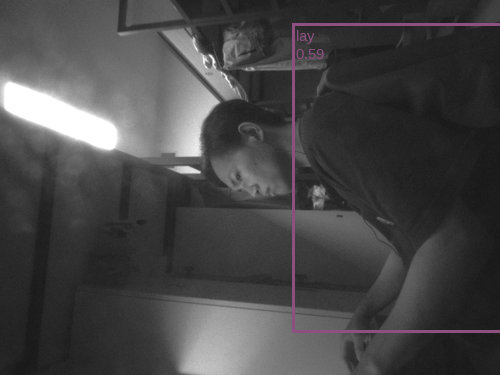

In [92]:
from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont

import tflite_runtime.interpreter as tflite 
from pycoral.adapters import common
from pycoral.adapters import detect
from pycoral.utils.dataset import read_label_file

def draw_objects(draw, objs, scale_factor, labels):
  """Draws the bounding box and label for each object."""
  COLORS = np.random.randint(0, 255, size=(len(labels), 3), dtype=np.uint8)
  for obj in objs:
    bbox = obj.bbox
    color = tuple(int(c) for c in COLORS[obj.id])
    draw.rectangle([(bbox.xmin * scale_factor, bbox.ymin * scale_factor),
                    (bbox.xmax * scale_factor, bbox.ymax * scale_factor)],
                   outline=color, width=3)
    font = ImageFont.truetype("LiberationSans-Regular.ttf", size=15)
    draw.text((bbox.xmin * scale_factor + 4, bbox.ymin * scale_factor + 4),
              '%s\n%.2f' % (labels.get(obj.id, obj.id), obj.score),
              fill=color, font=font)

# Load the TF Lite model
labels = read_label_file(LABELS_FILENAME)
interpreter = tflite.Interpreter(TFLITE_FILENAME)
interpreter.allocate_tensors()

# Resize the image for input
image = Image.open(INPUT_IMAGE)
_, scale = common.set_resized_input(
    interpreter, image.size, lambda size: image.resize(size, Image.ANTIALIAS))

# Run inference
interpreter.invoke()
objs = detect.get_objects(interpreter, score_threshold=0.4, image_scale=scale)

# Resize again to a reasonable size for display
display_width = 500
scale_factor = display_width / image.width
height_ratio = image.height / image.width
image = image.resize((display_width, int(display_width * height_ratio)))
draw_objects(ImageDraw.Draw(image), objs, scale_factor, labels)
image

##Download the model

In [93]:
from google.colab import files

files.download(TFLITE_FILENAME)
files.download(LABELS_FILENAME)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>